# PINN for Poisson equation

$$
\nabla^2 u = f
$$



In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Check device (use MPS if on silicon Mac or CUDA if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# print device
print(f"Using device: {device}")


Using device: mps


In [3]:
# Define the analytical solution
def analytical_solution(x, y):
    return torch.sin(4 * np.pi * (x + y)) + torch.cos(4 * np.pi * x * y)


In [4]:
# Define the model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 1)
        )

    def forward(self, xy):
        # xy represents the coordinates (x, y) concatenated
        u = self.net(xy)
        return u

def laplacian(u, xy):
    # Compute gradients du/dx and du/dy
    grads = torch.autograd.grad(outputs=u, inputs=xy, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    
    # Compute second derivatives 
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True, retain_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True, retain_graph=True)[0][:, 1]
    
    laplacian = u_xx + u_yy
    return laplacian 

def loss_pinn(model, xy, x_boundary, u_boundary, f):
    xy = xy.clone().detach().requires_grad_(True)
    x_boundary = x_boundary.clone().detach().requires_grad_(True)
    f = f.clone().detach()
    #predictions
    u = model(xy)
    #compute laplacian
    laplacian_u = laplacian(u, xy)
    physical_loss = torch.mean((laplacian_u - f)**2)
    # boundary condition loss
    u_boundary_pred = model(x_boundary)
    boundary_loss = torch.mean((u_boundary_pred - u_boundary)**2)
    return physical_loss +  10 * boundary_loss




In [5]:
# Problem setup
# Interior points (uniformly sampled within [0 , 1] x [0, 1])
x_interior = torch.rand((1000, 2), device=device)  # Random points in [0, 1] x [0, 1]
# f is the source term i.e. laplactian of u
x_interior = x_interior.requires_grad_(True)
u_analytical = analytical_solution(x_interior[:, 0], x_interior[:, 1])
f = laplacian(u_analytical, x_interior)
x_interior.requires_grad_(False) 

# Boundary points
x_boundary_x = torch.linspace(0, 1, 100, device=device).unsqueeze(1)
x_boundary = torch.cat([
    torch.cat([x_boundary_x, torch.zeros_like(x_boundary_x)], dim=1),
    torch.cat([x_boundary_x, torch.ones_like(x_boundary_x)], dim=1),
    torch.cat([torch.zeros_like(x_boundary_x), x_boundary_x], dim=1),
    torch.cat([torch.ones_like(x_boundary_x), x_boundary_x], dim=1),
], dim=0)

# Boundary condition values using the analytical solution
u_boundary = analytical_solution(x_boundary[:, 0], x_boundary[:, 1]).unsqueeze(1).to(device)




In [6]:

# Training
num_epochs = 50000
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_pinn(model, x_interior, x_boundary, u_boundary, f)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}, LR = {optimizer.param_groups[0]['lr']}")


Epoch 0: Loss = 43292.125, LR = 5e-05
Epoch 100: Loss = 43165.46875, LR = 5e-05
Epoch 200: Loss = 26625.669921875, LR = 5e-05
Epoch 300: Loss = 25564.73046875, LR = 5e-05
Epoch 400: Loss = 20320.671875, LR = 5e-05
Epoch 500: Loss = 16516.025390625, LR = 5e-05
Epoch 600: Loss = 15702.8466796875, LR = 5e-05
Epoch 700: Loss = 15428.5263671875, LR = 5e-05
Epoch 800: Loss = 15244.4365234375, LR = 5e-05
Epoch 900: Loss = 13908.486328125, LR = 5e-05
Epoch 1000: Loss = 12759.0458984375, LR = 5e-05
Epoch 1100: Loss = 12253.7099609375, LR = 5e-05
Epoch 1200: Loss = 12029.4169921875, LR = 5e-05
Epoch 1300: Loss = 11796.2880859375, LR = 5e-05
Epoch 1400: Loss = 11369.1845703125, LR = 5e-05
Epoch 1500: Loss = 11065.744140625, LR = 5e-05
Epoch 1600: Loss = 10806.80078125, LR = 5e-05
Epoch 1700: Loss = 10298.541015625, LR = 5e-05
Epoch 1800: Loss = 9714.1708984375, LR = 5e-05
Epoch 1900: Loss = 8821.033203125, LR = 5e-05
Epoch 2000: Loss = 7266.74267578125, LR = 5e-05
Epoch 2100: Loss = 5317.18408203

/opt/homebrew/Caskroom/miniconda/base/envs/deep/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636145/work/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


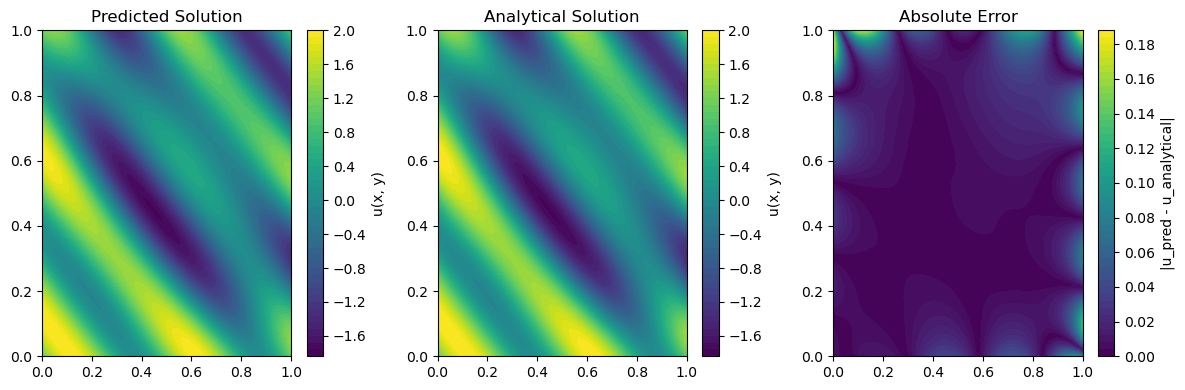

In [7]:
# Plotting: 
grid_x, grid_y = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 1, 100))
grid_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=-1).to(device)

# Predict solution on the grid
with torch.no_grad():
    u_pred = model(grid_points).reshape(100, 100).cpu().numpy()

# Calculate analytical solution on the grid
x_vals = grid_x.cpu().numpy()
y_vals = grid_y.cpu().numpy()
u_analytical = analytical_solution(grid_x, grid_y).cpu().numpy()

# Plot the predicted solution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.contourf(x_vals, y_vals, u_pred, levels=50)
plt.colorbar(label="u(x, y)")
plt.title("Predicted Solution")

# Plot the analytical solution
plt.subplot(1, 3, 2)
plt.contourf(x_vals, y_vals, u_analytical, levels=50)
plt.colorbar(label="u(x, y)")
plt.title("Analytical Solution")

# Plot the difference
plt.subplot(1, 3, 3)
plt.contourf(x_vals, y_vals, np.abs(u_pred - u_analytical), levels=50)
plt.colorbar(label="|u_pred - u_analytical|")
plt.title("Absolute Error")

plt.tight_layout()
plt.show()